<a href="https://colab.research.google.com/github/akhsassoualid/Prediction_of_making_a_deposit_by_clients/blob/master/First_look_at_Attijariwafa_bank_stock_price_after_COVID_19_with_SARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction:**

---
Most use cases of time series are applied on a stock price of some known companies, such as APPLE, NETFLIX, AMAZON, FACEBOOK, but what about Moroccan companies, that are characterized with a little difference from the rest of the world companies, what about the stock price of ATTIJARIWAFA BANK or BMCE, for example?

During the period of COVID-19, the stock market in different regions knew, a decreasing trend, due to the lockdown that was applied in most countries.  
For this reason, our project aims to apply a time serie modeling using SARIMAX model **as our first trying on**, in order to predict the trend of the stock price of a huge bank company in Morocco, we talk here about Attijariwafa Bank. In fact, the predictions we try to generate for this company could give us an idea of how the stock market of the Moroccan's banking companies will behave.


**But first, what is SARIMAX model ?**

SARIMAX(p,d,q)(P,D,Q,S) = **S**easonal component related to seasonal order **(P,D,Q,S)** + **ARIMA(p,d,q)** model + e**X**ogene variable. 

A SARIMAX model is an ARIMA model with its order that defines it (p,d,q), to which we add a seasonal part represented by the seasonal orders (P,D,Q,S), S is the length of the cyclic season. In case we consider another variable in fitting the model, we say we had added an exogen variable to the SARIMA model.

To build a SARIMAX model, data must follow a process:

> - We start with testing whether the time serie is stationary or not. With stationarity, we mean that statistical properties such as mean, variance, autocorrelation are all constant over time.
The purpose of the stationarity test, which could be done with the Dicky Fuller test, is to make the application of SARIMAX models suitable for data. In fact, SARIMAX needs a time serie to be stationary, otherwise, a transformation should be applied. ***(This step is done in part 2, we plot ACF and PACF to confirm that the data wasn't stationary)***

> - If the time serie isn't stationary, then we use a different order of differencing to make it stationary. By order of differencing equal to 1 for example, we mean that we apply SARIMAX on a time serie that is the output of **delta(Y(t)) = Y(t) - Y(t-1)**. Once we get this new time serie, we plot its ACF and PACF to estimate the possible orders of the SARIMAX model. The ACF and PACF at each order must be out of the confidence interval (Being out of this interval means it's statistically significative and so different from zero) so that this order could be taken into consideration. ***(This step was done in part 3, we test order 1 of differencing and also order 2)***

> - We select a train and test sets, first one to fit SARIMAX model, and the second one to generate prediction out of sample(confront the model to new data). To note that we run a grid search for SARIMAX's orders (p and q), and select the one with the lowest Mean Absolute Error(MAE). ***(This step is mentioned in part 4 where we run the grid search, we predict in the sample, and out of the sample)***

> - The seasonal order could be estimated using the ACF and PACF plots of a new time series constructed by the the normal and seasonal differences we apply on the original data. ***(This part is done in part 5, we use the seasonal length S to apply the seasonal difference)***.


**Install and Import libraries:**

---
First of all, we begin with installing with **investpy** to scrap data, and **pmdarima** to use auto_arima for selecting the best order for ARIMA/SARIMA model. 

In [4]:
pip install investpy

In [5]:
pip install pmdarima

In [0]:
# Import important libraries
#-----------------------------
# Imported libraries for dataframes, arrays, and plots
import investpy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Imported libararies for time serie modeling
import statsmodels.api as sm
import scipy.stats as scs
import itertools as itr
import pmdarima as pm
import joblib
from datetime import  datetime, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

**1.Important Functions:**

---

> In this part of project, we build several functions, that could simplify our task of modeling with SARIMAX. 
  - **add_mult** : It's a Function that identify if a time serie is Additive or  Multiplicative.
  - **stationarity** : It's a function that test if a time serie is stationary or not based on the p-value of the Dicky Fuller test.
  - **acf_pacf_plots** : It plots the Autocorrelation (ACF) and Partial Autocorrelation (PACF) of a time serie, or a detrended time serie.
  - **multmodels** : Fit Mulitple SARIMAX models based on a grid search of orders (p,d,q), and seasonal order (P,D,Q,S).
  - **evaluate** : Function taht evaluate the models, It returns a diagnostics plots, and/or the summary of the fitted model.
  - **predictions** : Returns the predictions in sample and out sample of the model.
  - 

In [0]:
# Functions:
# ----------
# Resample data by month frequency to test if it's additif or multiplicatif
def add_mult(data, ts, window, alpha=0.05):
  """data : A Data frame that containes time series
    ts : a column of the data frame, it's a time serie
    window : the period we use in rolling the time serie
    alpha : The marge of error to which we compare the p-value of the test """
  dff = data[ts]
  dff_mean = dff.rolling(window).mean()
  dff_mean = dff_mean.dropna()
  dff_std = dff.rolling(window).std()
  dff_std = dff_std.dropna()
  reg = sm.OLS(dff_mean, dff_std)
  res = reg.fit()
  if res.pvalues[0] < alpha:
    print("The time serie is Multiplicative")
  else:
    print("The time serie is additive")
  return res.pvalues[0]
 

# Test stationarity with ADF and KPSS tests: 
def stationary(data, ts, alpha):
  """ data : A data frame that contains one or multiple time series
    ts : A time serie in this data frame
    alpha : The marge of error to which we compare the p-value of the test """
  res_ADF = sm.tsa.stattools.adfuller(data[ts]) 
  if res_ADF[1] < alpha:
    print('The series is STATIONARY since The ADF test shows a p-value of {}'.format(res_ADF[1]))
  else:
    print('The series is NOT STATIONARY since The ADF test shows a p-value of {}'.format(res_ADF[1]))

# Plot the ACF and PACF
def acf_pacf_plots(data, ts, lags , figsize=(25,7), alpha=0.05, zero=False):
  """data : A data frame that contains one or multiple time series
     ts : A time serie in this data frame
     lags : number of lags
     figsize : The size of the plots
     alpha : The marge of error to which we compare the p-value of the test
     zero : if True, we add zero as a lag, if false it's not included in plots"""
  fig, (ax1, ax2)=plt.subplots(1,2,figsize=figsize)
  plot_acf(data[ts], ax=ax1, lags=lags, alpha=alpha, zero=zero)
  plot_pacf(data[ts], ax=ax2, lags=lags, alpha=alpha, zero=zero)
  plt.show()

# Fit multiple models
def multmodels(ts, p, d, q, period = None, trend=['c','t'], exo = None, seasonality=False, P=None, D=None, Q=None):
  """ts : It's a time serie in a data frame, for example df['time_serie']
      p : A range of possible integers for p
      q : A range of possible integers for q
      d : The order of differencing of the time serie
      period : the length of the seasonality, if this length is 30 days, period will be equal to (30,)
      trend : a list of possible kind of trend
      exo : the variable added as exogen variable, if there is no variable, exo takes None
      seasonality : If true, then we are fitting a SARIMAX(p,d,q)(P,D,Q,S), if False we are fitting a SARIMAX(p,d,q) model
      P : A range of possible integers for seasonal order P
      Q : A range of possible integers for seasonal order Q
      D : The order of seasonal differencing of the time serie"""
  AIC = []
  BIC = []
  order = []
  Trend = []
  MAE = []
  if seasonality == True:
    Order = [(x[0], x[1], x[2], x[3], x[4], x[5], x[6]) for x in list(itr.product(p, d, q, P, Q, D, trend))]
    for i in range(0,len(Order)):
      mod = SARIMAX(ts, order=Order[i][0:3], trend=Order[i][6], exog=exo, seasonal_order=Order[i][3:6]+period)
      res = mod.fit()
      AIC.append(res.aic)
      BIC.append(res.bic)
      order.append(Order[i][0:6])
      Trend.append(Order[i][6])
      MAE.append(np.mean(np.abs(res.resid)))
    combination = pd.DataFrame({'order':order, 'trend':Trend, 'AIC':AIC, 'BIC':BIC, 'MAE':MAE})
    return combination
  else:
    Order = [(x[0], x[1], x[2], x[3]) for x in list(itr.product(p, d, q,trend))]
    for i in range(0,len(Order)):
      mod = SARIMAX(ts, order=Order[i][0:3], trend=Order[i][3], exog=exo)
      res = mod.fit()
      AIC.append(res.aic)
      BIC.append(res.bic)
      order.append(Order[i][0:3])
      Trend.append(Order[i][3])
      MAE.append(np.mean(np.abs(res.resid)))
    combination = pd.DataFrame({'order':order, 'trend':Trend, 'AIC':AIC, 'BIC':BIC, 'MAE':MAE})
    return combination

def evaluate(data, pdq, trend, plot = 0, figsize=(15,10)):
  """data : A time serie in a data frame, must precise which coluln we are working with, for example df['time_serie']
    pdq : (p,d,q) a tuple that represent the orderof ARIMA model
    trend : equal to 'n', 'c', 't', or 'ct' 
    plot : if equal to 0, we get the summary, if 1 then we get diagnostics plots, if neither 0 or 1 then we get both of them 
    figsize : The size of the figure if we plots diagnostics """
  model = SARIMAX(data, order=pdq, trend=trend)
  result = model.fit()
  # Return only summary
  if plot == 0:
    S = result.summary()
    return S
  # Return diagnostoc plots
  elif plot == 1: 
    # Plots diagnostics
    print('The evaluation plots for ARIMA'+str(pdq)+' with a trend '+str(trend))
    result.plot_diagnostics(figsize=figsize)
    plt.show()
  # Return both summary and plots
  else:
    S = result.summary()
    print('The evaluation plots for ARIMA'+str(pdq)+' with a trend '+str(trend))
    result.plot_diagnostics(figsize=figsize)
    plt.show()
    return S    

def predictions(ts, train, test, data_name, IN, lag_of_pred, order, trend, plot=True):
  """ ts : The name of the time serie in the train data frame
      train : The train set 
      test : The test set 
      data_name : The name of the data frame 
      IN : True we want prediction in Sample, False means we confront the model to new data frame (test set in that case)
      lags_of_pred : Number of point time we want to predict, if negative, it mean we are looking for prediction in sample, if positive, then prediction are out of sample
      order = (p,d,q) the order of the model
      trend : 'c', 'n', 't', 'ct' one of these types of trend
      plot : If we want to plot the prediction in sample"""
  model = SARIMAX(train[ts], order=order, trend=trend)
  result = model.fit()
  if np.logical_and(IN==True, lag_of_pred<0):
    res_pred = result.get_prediction(start=lag_of_pred)
    pred = res_pred.predicted_mean
    interval = res_pred.conf_int()
    l = interval.iloc[:,0]
    u = interval.iloc[:,1]
    if plot == True:
      plt.figure(figsize=(20,7)) 
      plt.plot(train.index, train[ts], label=ts+'Observed', color='b')
      plt.plot(pred.index, pred, label='Predicted', color='g')
      plt.fill_between(l.index, l, u, color='pink')
      plt.xlabel('Date')
      plt.ylabel(data_name)
      plt.title('In sample preditcion with ARIMA'+ str(order)+' and trend of '+trend)
      plt.grid(True)
      plt.legend()
      plt.show()
    return pred
  elif np.logical_and(IN==False, lag_of_pred>0):
    res_forec = result.get_forecast(steps=lag_of_pred)
    forec = res_forec.predicted_mean
    forec.index = test.index
    N = str(order)+trend
    forecast = pd.DataFrame({'ARIMA'+N:forec}, index=forec.index)
    return forecast
  else : 
    print('Please you need to review the value given to IN and lag_of_pred')

# Decomposition of the time serie and plots of components
def plot_compo(ts, type_ts, period, figsize = (15,15)):
  """ts : the time serie we decomose, for example df['time_serie']
    type_ts : additve or multiplicative
    period : the frequence of seasonality
    figsize : The size of figures """
  decomp = sm.tsa.seasonal_decompose(x=ts,model=type_ts, freq=period)
  df_decomp = pd.DataFrame({'observed': decomp.observed,
                        'trend' : decomp.trend,
                        'seasonal' : decomp.seasonal,
                        'residual' : decomp.resid})
  df_decomp=df_decomp.dropna()
  plt.figure(figsize=figsize)
  plot_number = 1
  for var in df_decomp.columns:
    ax = plt.subplot(4,1, plot_number)
    sns.lineplot(data=df_decomp[var], palette="RdBu", label=var, dashes=True)
    plt.title('The plot of the '+var, fontsize = 'x-large')
    plot_number = plot_number + 1
    plt.tight_layout()
  return df_decomp

**2. Import and explore Attijariwafa Bank'stock price**

---
The Imported data from investing.com concerns 6 features: {Open, High, Low, Close, Volume, Currency}. We focus on the close price of the stock and its volume. In the Trading field, most traders focus their strategies on stock's price and volume of previous lags for future predictions.

In [16]:
#2. Import the data 
df = investpy.get_stock_historical_data(stock='ATW', country='morocco', from_date='01/01/2007', to_date='30/05/2020')
df = df[['Close', 'Volume']]
df.head()

,Close,Volume
Date,,
2007-01-02,231.0,3460
2007-01-03,230.1,91120
2007-01-04,238.0,2920
2007-01-05,241.1,128950
2007-01-08,244.0,21630


**2.1 Explore the type, stationarity of the time serie**

We will focus on the Close price of the stock. It will represent the price of Attijariwafa Bank stock. 

The time serie is Multiplicative


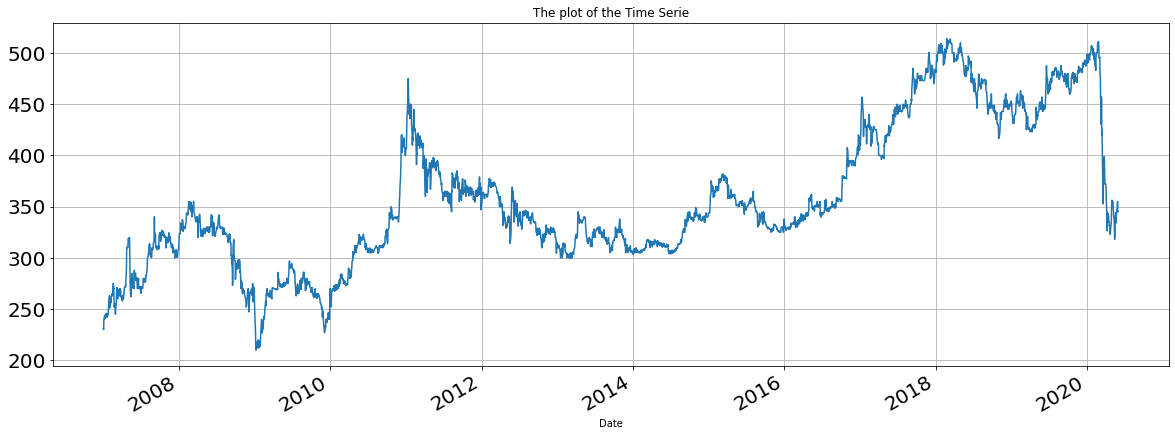

The series is NOT STATIONARY since The ADF test shows a p-value of 0.23245491383948813


In [0]:
# 2.1 Plot the TS and test its stationarity
# Identify the type of TS: additive or multiplicative
add_mult(df, 'Close', window=30) # we set window at 30 , it mean we resample with mean by each month
# Plot the TS
df['Close'].plot(grid=True, figsize=(20,7), title='The plot of the Time Serie', fontsize=20)
plt.show()
# Test Stationarity
stationary(data=df, ts='Close', alpha=0.05)

**Conclusion**:

- The stock price data is multiplicative. By multiplicative, we mean there is a multiplication between the components of the time serie (seasonality + Trend + Residuals). It means with an increasing trend, we will have a proportional increment on the amplitude of the seasonality too.
- The type of time serie is necessary to decompose it.
- Since this analysis shows the existence of seasonality and trend, we are approximately sure that the time serie is non-stationary.
- The ACF plots will confirm the Non stationarity.

**2.2 Plotting the correlogram of the time serie:**

We will plot the ACF and PACF plots to confirm the non-stationaruty of the dataset.

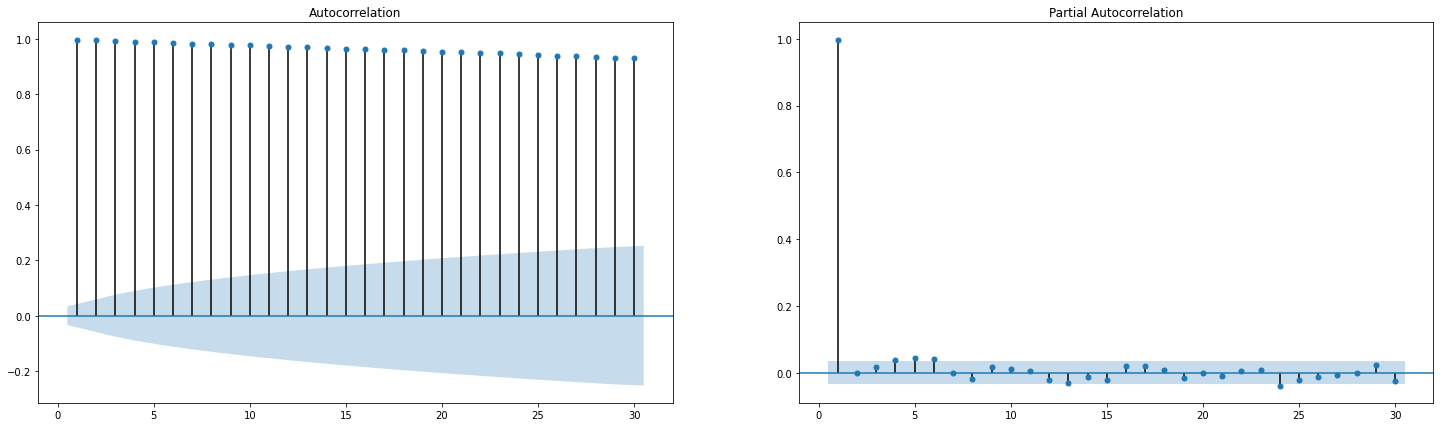

In [0]:
# 2.2 Plot ACF and PACF of df
acf_pacf_plots(data=df, ts='Close', lags=30)

**Conclusion:**

The autocorrelation plots shows non significatif correlations between the time serie and its previous lags. In fact, any time serie with such plot of autocorrelation confirms the non stationarity.

**2.3 About normality of the time serie:**

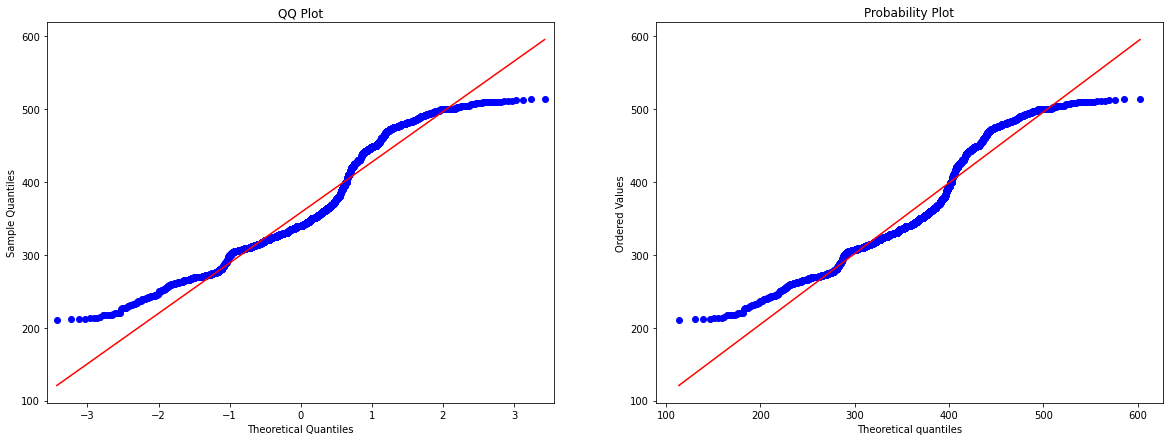

In [0]:
# 2.3 Normality of the time serie
fig, (qq_ax, prob_ax)=plt.subplots(1,2,figsize=(20,7))
sm.qqplot(df['Close'], line='s', ax=qq_ax)
qq_ax.set_title('QQ Plot')        
scs.probplot(df['Close'], sparams=(df['Close'].mean(), df['Close'].std()), plot=prob_ax)
plt.show()

**Conclusion:**

The comparison between quantiles of the time serie and quantiles of the theoretical normal distribution shows no similarity

**3. Move to first and second difference of the time serie to make it stationary:**

**3.1 Move to first difference to make df stationary:**

The series is STATIONARY since The ADF test shows a p-value of 0.0


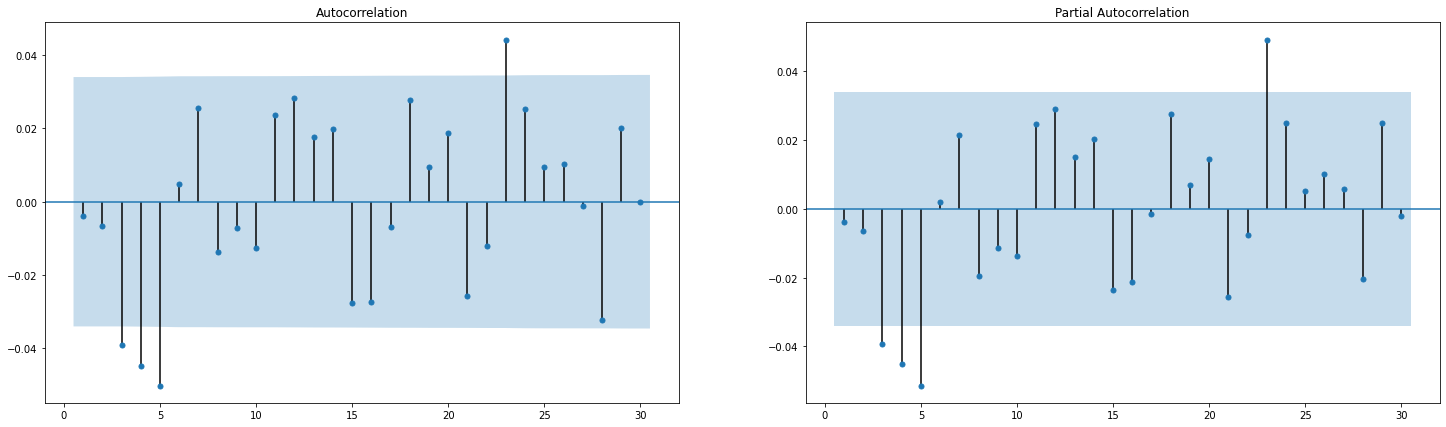

In [0]:
# 3. Make df Stationary with order 1 and 2 of difference
# 3.1 First Difference
df1 = df.diff()
df1 = df1.dropna()
# Test stationarity of df1
stationary(data=df1, ts='Close', alpha=0.05)
# Plot ACF and PACF of df1
acf_pacf_plots(data=df1, ts='Close', lags=30)

**Conclusion**:

The Dicky Fuller test shows stationarity of the first difference, While ACF and PACF show ARIMA orders of q=p={3,4,5}. The Partial autocorrelation function and autocorrelation function perform significance on these orders. By significance, we mean that these functions are statistically different from zero.

**3.2 Move to the second difference of the time serie:**

We move to the second difference to figure out if we can get ACF and PACF plots that give readable orders of the ARIMA model.

The series is STATIONARY since The ADF test shows a p-value of 0.0


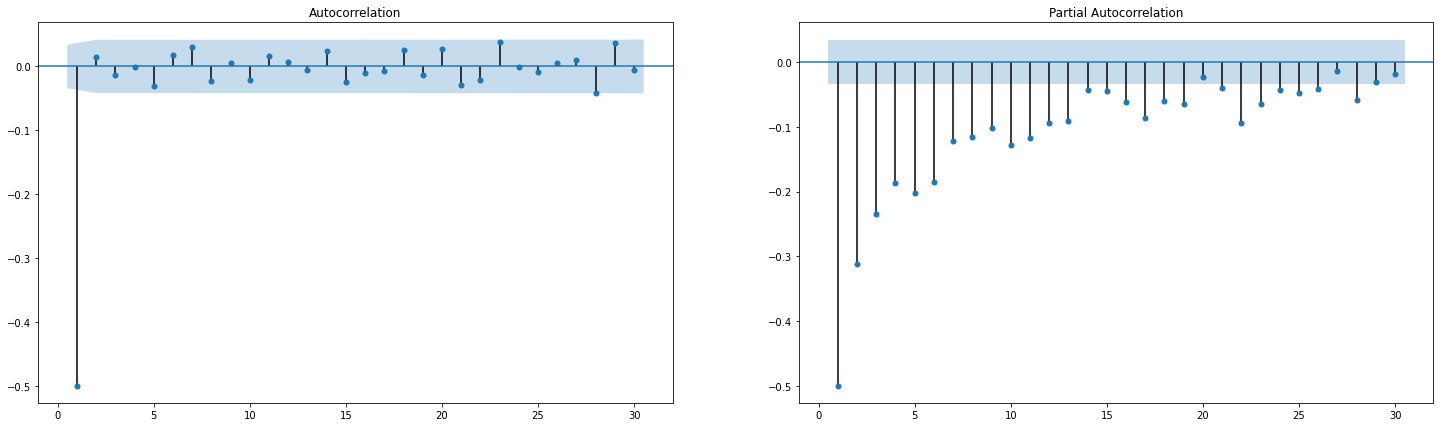

In [0]:
# 3.2 Second Difference
df2 = df.diff().diff()
df2 = df2.dropna()
# Test stationarity of df2
stationary(data=df2, ts='Close', alpha=0.05)
# Plot ACF and PACF of df1
acf_pacf_plots(data=df2, ts='Close', lags=30)

**Conclusions:**
- The second difference of the time serie is stationary.
In that case of ACF plot, we notice that all autocorrelation functions are statistically non-significant, except the lag one. To note that a time serie with such ACF could note model correctly the dataset with ARIMA.
- So, We will use the first difference as a stationary time serie for the ARIMA model.
- We will use a grid search based on p and q orders, this grid search allows to cover any error of interpreting the p and q orders. 

**4. Model with SARIMA on train set and evaluate and compare with test sets.**

---
**4.1 Split the time serie to train set and test sets (two test sets):**

- We fit the ARIMA models on the train data, It begins from 01-01-2007 and ends on 30-04-2020.
- The test set concerns a timeline from 01-05-2020 to 25-05-2020, to compare multiple predictions with.

In [0]:
# 4.1 Split the time serie to train test sets
train = df[:'04-30-2020']
test = df['05-01-2020':]

**4.2 Run multiple ARIMA models:**

- We use the built function multmodels to train different ARIMA modesl using the a range of orders with first difference for the train dataset.
- This function return all possible combinations with its AIC, BIC, and Mean Absolute Error of each model compared to real value with training set.

In [0]:
# 4.2 Fit multiple models
combinations = multmodels(ts=train['Close'], p=range(3,6), d=range(1,2), q=range(3,6), trend=['c','t','n','ct'])

In [0]:
combinations.head()

,order,trend,AIC,BIC,MAE
0,"(3, 1, 3)",c,19596.475216,19645.298329,3.158697
1,"(3, 1, 3)",t,19612.924533,19661.747646,3.149887
2,"(3, 1, 3)",n,19594.637105,19637.357329,3.161042
3,"(3, 1, 3)",ct,19614.255847,19669.181849,3.151770
4,"(3, 1, 4)",c,19601.097412,19656.023414,3.160544


**4.3 Select the best two model based on each criteria (AIC, BIC, MAE):**

In [0]:
# 4.3 Best ARIMA's order based on:
# AIC:
nbr_model=3 # Number of model we want to select based on each criteria
aic_opt = combinations.sort_values('AIC').loc[:,['order','trend','MAE']].head(nbr_model)
print(aic_opt)
#cBIC:
bic_opt = combinations.sort_values('BIC').loc[:,['order','trend','MAE']].head(nbr_model)
print(bic_opt)
#cMAE:
MAE_opt = combinations.sort_values('MAE').loc[:,['order','trend','MAE']].head(nbr_model)
print(MAE_opt)

# Drop duplcate orders
chosen_order = [aic_opt.iloc[i,0]+(aic_opt.iloc[i,1],) for i in range(0,nbr_model)] + [bic_opt.iloc[i,0]+(bic_opt.iloc[i,1],) for i in range(0,nbr_model)] + [MAE_opt.iloc[i,0]+(MAE_opt.iloc[i,1],) for i in range(0,nbr_model)]
print('The chosen models based on all cretria are:{}'.format(list(set(chosen_order))))

        order trend       MAE
2   (3, 1, 3)     n  3.161042
0   (3, 1, 3)     c  3.158697
14  (4, 1, 3)     n  3.161380
        order trend       MAE
2   (3, 1, 3)     n  3.161042
0   (3, 1, 3)     c  3.158697
14  (4, 1, 3)     n  3.161380
       order trend       MAE
1  (3, 1, 3)     t  3.149887
7  (3, 1, 4)    ct  3.150839
5  (3, 1, 4)     t  3.151077
The chosen models based on all cretria are:[(3, 1, 4, 't'), (3, 1, 3, 'c'), (4, 1, 3, 'n'), (3, 1, 3, 'n'), (3, 1, 3, 't'), (3, 1, 4, 'ct')]


**Conclusion:**

The grid search shows that 5 models give the best results of ARIMA based on the previous creteria, we talk here about: (3, 1, 4, 't'), (4, 1, 3, 'n'), (3, 1, 3, 'n'), (3, 1, 4, 'cT'), (3, 1, 3, 'C'), and (3, 1, 3,'t'). the 4th element of each model represent how we model the trend inside the ARIMA models.

**4.3 Get the summaries of each model:**

In [0]:
# 4.3 Print the summary of the 4 models
for i in range(0,4):
  print(evaluate(df['Close'], pdq = chosen_order[i][0:3], trend=chosen_order[i][3], plot=0))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3324
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -9854.786
Date:                Sat, 30 May 2020   AIC                          19723.572
Time:                        23:47:56   BIC                          19766.332
Sample:                             0   HQIC                         19738.873
                               - 3324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6182      0.100     16.146      0.000       1.422       1.815
ar.L2         -1.5601      0.105    -14.826      0.000      -1.766      -1.354
ar.L3          0.6443      0.095      6.802      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3324
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -9854.724
Date:                Sat, 30 May 2020   AIC                          19725.448
Time:                        23:48:05   BIC                          19774.317
Sample:                             0   HQIC                         19742.935
                               - 3324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0117      0.021      0.543      0.587      -0.030       0.054
ar.L1          1.6361      0.098     16.668      0.000       1.444       1.829
ar.L2         -1.5844      0.102    -15.543      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3324
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -9854.939
Date:                Sat, 30 May 2020   AIC                          19725.878
Time:                        23:48:09   BIC                          19774.747
Sample:                             0   HQIC                         19743.365
                               - 3324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6056      0.141     11.386      0.000       1.329       1.882
ar.L2         -1.5669      0.127    -12.306      0.000      -1.817      -1.317
ar.L3          0.6434      0.119      5.412      0.0

**Conclusion:**

- As shown below, all models have a **Prob(Q)** with a p-value higher than the allowed error of 0.05, which means we will accept the Null hypothesis of no correlation between residuals of the model.
- However, it seems that residual for all models aren't normal since they have a **Prob(JB)** with a p-value less than the allowed error of 0.05, which make us reject the Null hypothesis of residuals being normal.
- All models confirm that the hypothesis that residual are homoscedastic is verified since their **prob(H)** is higher than 0.05, so no need to move for ARCH and GARCH models.

**4.4 Predictions of the models in and out of training set:**

**4.4.1 Predictions in sample with model ARIMA:**

- We will first compare the chosen model outputs with some time points of the training. It will be clear the within-sample points we get similar values with chosen ARIMA. We take just one chosen example to compare, we use the ARIMA(3, 1, 3, 'n').
- We select that model from the **chosen_order list**.

In [0]:
print(chosen_order)

[(3, 1, 3, 'n'), (3, 1, 3, 'c'), (4, 1, 3, 'n'), (3, 1, 3, 'n'), (3, 1, 3, 'c'), (4, 1, 3, 'n'), (3, 1, 3, 't'), (3, 1, 4, 'ct'), (3, 1, 4, 't')]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


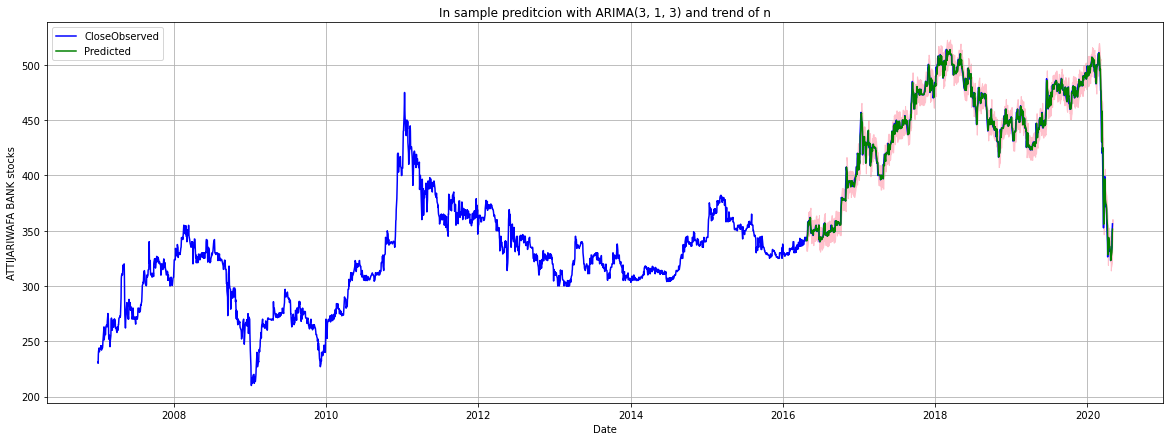

In [0]:
# 4.4 Prediction in and out of training set:
# 4.4.1 Predictions in sample with model ARIMA(3, 1, 3, 'n')
inpred = predictions(ts='Close',train=train, test=test, data_name='ATTIJARIWAFA BANK stocks', IN=True, order=chosen_order[0][0:3], trend=chosen_order[0][3], lag_of_pred=-1000)

**Let's test the last model, for the sake of verification, we try the ARIMA(3,1,4,'ct')**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


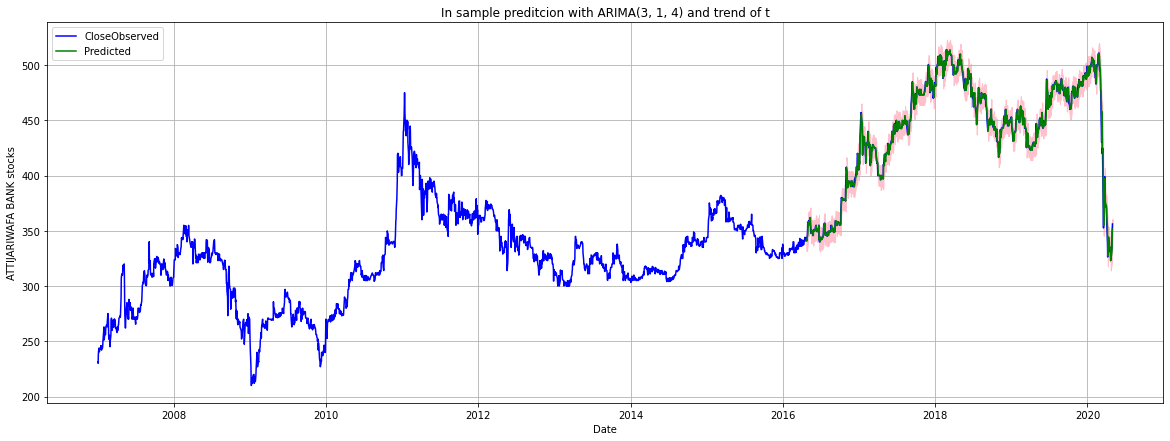

In [0]:
# Predictions in sample with model ARIMA(3, 1, 4, 'ct')
inpred = predictions(ts='Close',train=train, test=test, data_name='ATTIJARIWAFA BANK stocks', IN=True, order=chosen_order[-1][0:3], trend=chosen_order[-1][3], lag_of_pred=-1000)

**4.4.2 Predictions (out of the treaining set) on test set:**

We try to fit prediction for the next period of the test set. It mean we fit prediction from 21-04-2020 to 30-04-2020. We will compare the results of different models.

In [0]:
# 4.4.2  Prediction out of sample of train time serie
out_compar = pd.DataFrame({'test':test['Close']}, index=test.index)
for i in range(0,len(chosen_order)):
  pred = predictions(ts='Close',train=train, test=test, data_name='ATTIJARIWAFA BANK stocks', IN=False, order=chosen_order[i][0:3], trend=chosen_order[i][3], lag_of_pred=len(test))
  out_compar = pd.concat([out_compar, pred], axis=1)

**We summarize the prediction in a data frame**

In [0]:
out_compar

,test,"ARIMA(3, 1, 3)n","ARIMA(3, 1, 3)c","ARIMA(4, 1, 3)n","ARIMA(3, 1, 3)n","ARIMA(3, 1, 3)c","ARIMA(4, 1, 3)n","ARIMA(3, 1, 3)t","ARIMA(3, 1, 4)ct","ARIMA(3, 1, 4)t"
Date,,,,,,,,,,
2020-05-04,355.00,355.499021,355.542411,355.505670,355.499021,355.542411,355.505670,355.433819,355.232478,355.353300
2020-05-05,355.00,354.941399,355.014534,354.992785,354.941399,355.014534,354.992785,354.826514,354.300371,354.540942
2020-05-06,348.50,354.529572,354.646951,354.619698,354.529572,354.646951,354.619698,354.493392,353.723569,354.080973
2020-05-07,346.05,354.290502,354.471508,354.390909,354.290502,354.471508,354.390909,354.514523,353.484872,353.952689
2020-05-08,341.95,354.193333,354.437759,354.281503,354.193333,354.437759,354.281503,354.734308,353.505452,354.075385
2020-05-11,336.50,354.147807,354.434704,354.227177,354.147807,354.434704,354.227177,354.946285,353.545527,354.212501
2020-05-12,325.00,354.073914,354.382811,354.166196,354.073914,354.382811,354.166196,355.029509,353.514500,354.276426
2020-05-13,318.10,353.964085,354.294849,354.083886,353.964085,354.294849,354.083886,354.983206,353.408192,354.265187
2020-05-14,322.70,353.873580,354.244366,354.012388,353.873580,354.244366,354.012388,354.880003,353.273090,354.226560


**Conlsuion:**
 - Evene if the prediction in sample look very good, but with new data out of the sample, predictions with all possible optimal models show what we call in trading a **trend range**, while with real data, we notice a growing trend of stock.
 - The trend range (where the stock price is stable) could be a result of not taking into consideration the seasonal part of the time serie.
 - The next part of the project will try to take it into consideration.

**5. Add seasonality component to improve the predictions:**

---
**5.1 Decompose the time serie into its components (Trend + Seasonality + Residual):**

Since the data is daily, so we will use a period of 30 days (30-time points) to decompose the time serie. In fact, the seasonality plot will prove if our choice of the period is perfect or not, if the variation for each 30-time points looks the same, we presuppose that our hypothesis of periodicity is good.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


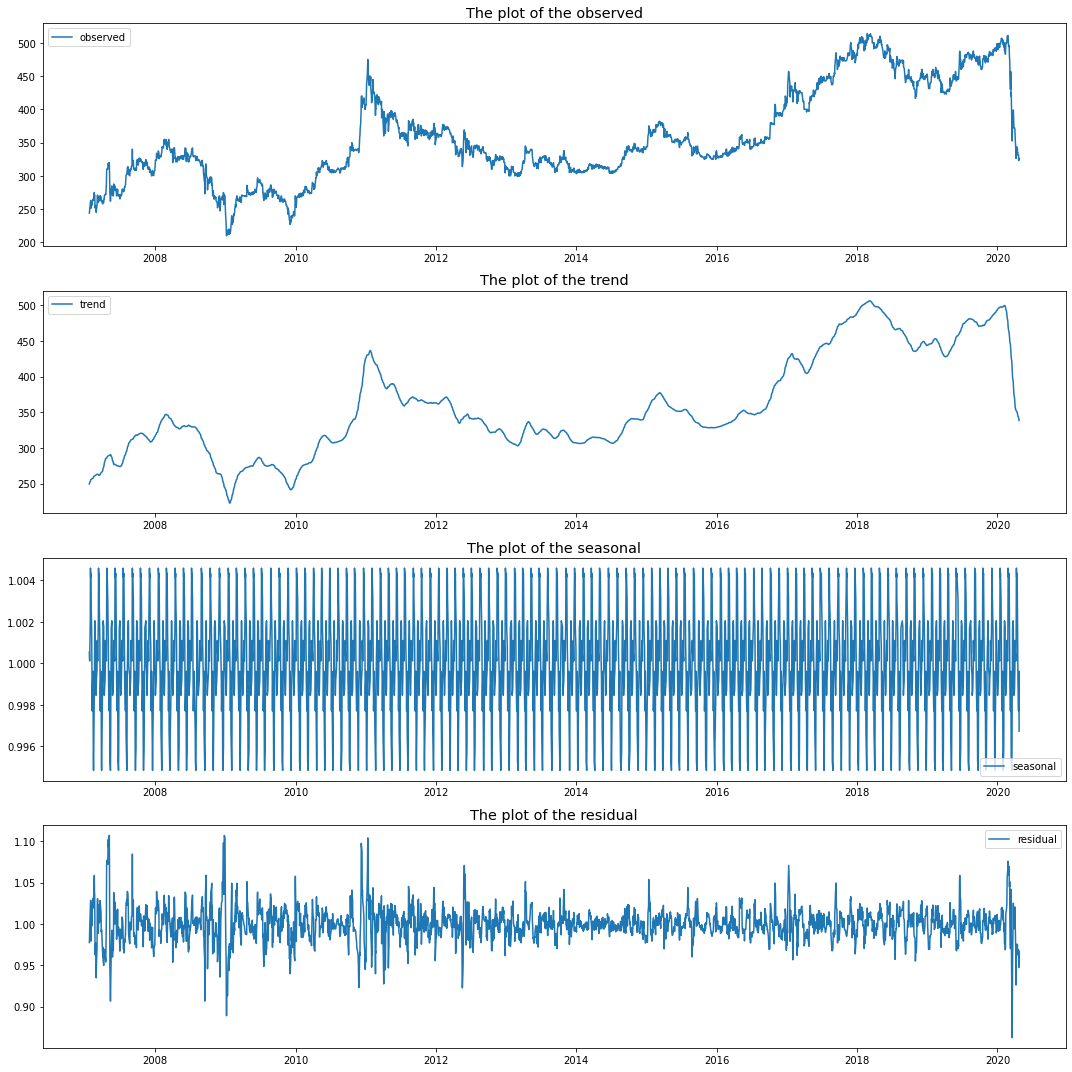

In [0]:
# 5. Add seasonality to improve the model
# 5.1 Decompose the TS to its components (Trend + seasonality + Residual)
dfn = plot_compo(ts = df['Close'], type_ts = 'multiplicative', period=30) # The lenght of a season will be 30 days

**Conclusion:**
 - The seasonality plot shows the same pattern of variation for each period (30 days). We will use 30 days as the length of a season.

**5.2 The non seasonal ACF and PACF to identify the order of ARIMA:**
 
To make the time serie stationary, we need to apply seasonal differecing, instead of substractin the most recent value of the time serie, we substract the serie from one seasonal cycle ago **(data.diff().diff(S))** where S is the lenght of a seasonal cycle.

The series is STATIONARY since The ADF test shows a p-value of 8.343286607289312e-29


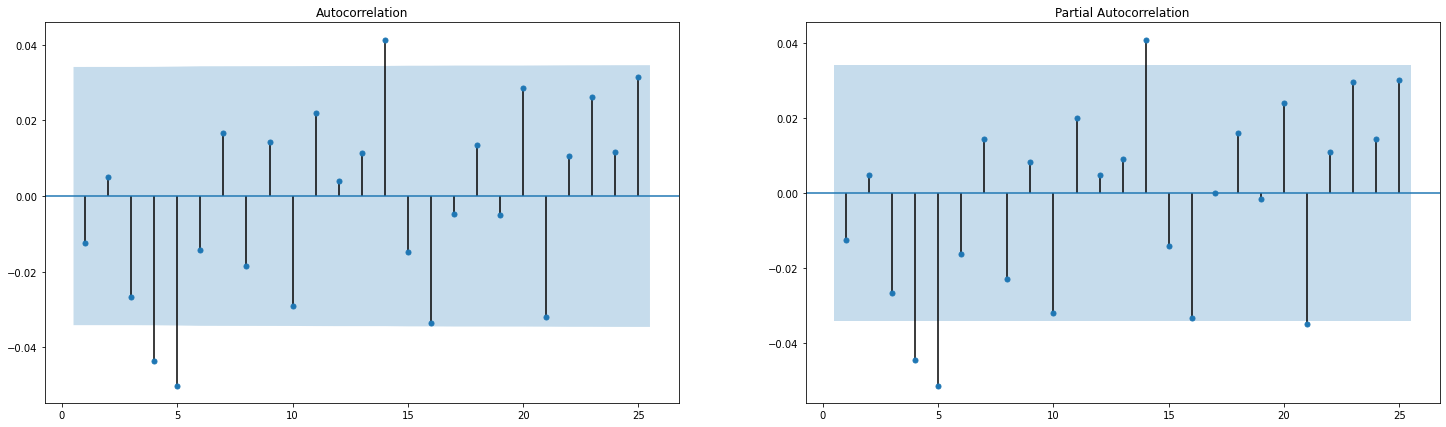

In [0]:

# 5.2 ACF and PACF of df with a lenght of seasonal cycle of 30
dfS = df.diff().diff(30)
dfS = dfS.dropna()
stationary(data=dfS, ts='Close', alpha=0.05)
acf_pacf_plots(data=dfS, ts='Close', lags=25)

**Conclusion:**
 - It seems that the seasonal differencing of Attijariwafa Bank stock is stationary, so we can implement it on a SARIMA model.
 - The ACF and PACF shows that p and q orders can be equal to 4 or 5.

Right now, we have to find the seasonal order P and Q. We plot the ACF and PACF of dfS at multiple seasonal steps, that will be defind before runing acf_pacf_plot function.

**5.3 Seasonal order of dfS:**

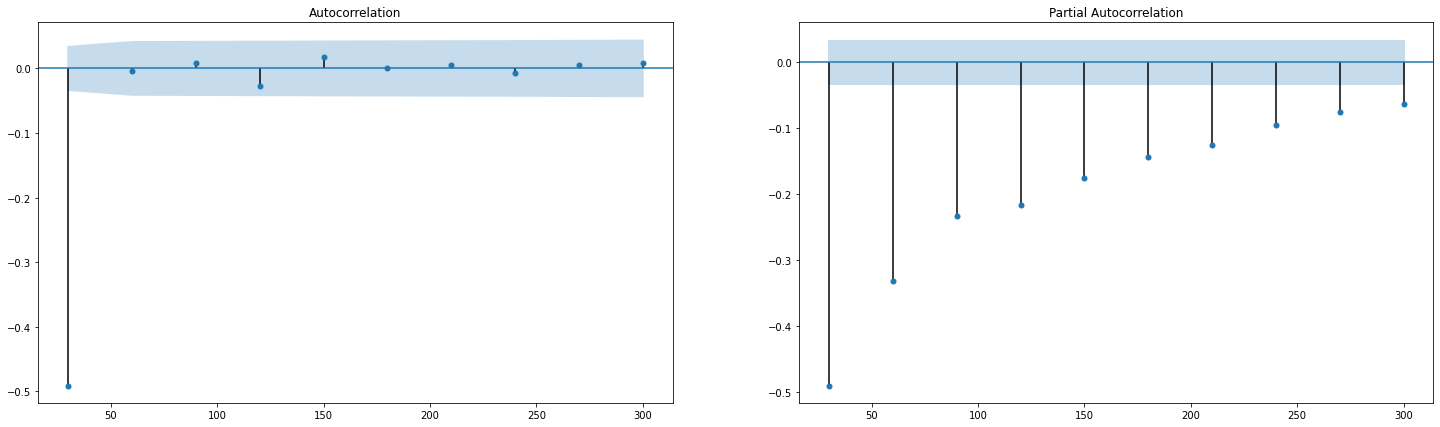

In [0]:
# 5.3 Identify dfS seasonal orders:
lags = [k for k in range(30,301,30)] # We define 6 seasonal steps
acf_pacf_plots(dfS, ts='Close', lags=lags, zero=False)

**Conclusion:**
- The possible order will be a Q={1,2,...,9} and P will be 1

**5.3 Prediction out of sample with seasonal component in the model:**

 - At this part, there are many possible combinations of order if we include the seasonal orders. We will use just one combination and compare its predictions with the test set. We use a SARIMAX(4,1,4)(1,1,2,30) with a 'n' trend.

 - In fact, the choice of the model is to assure that the model with seasonal order can detect different trend over different period.

**5.3.1 Fit a SARIMA model with seasonal orders:**

In [18]:
# 5.3.1 Fit SARIMA with seasonal orders
mod = SARIMAX(train['Close'], order=(4,1,4), trend='n', seasonal_order=(1,1,2,30))
res = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

**5.3.2 Predictions compared to test set (Out of sample)**

In [19]:
# 5.3.2 Predictions compared to test set (Out of sample)
res_forec = res.get_forecast(steps=len(test))
forec = res_forec.predicted_mean
forec.index = test.index

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


**5.3.3 Plots the test set and compare it with preditcions:**

In [20]:
# 5.3.3 Plots the test set and compare it with preditcions:
test_forec = pd.DataFrame({'test':test['Close'], 'forec':forec, 'Error': test['Close']-forec}, index = test.index)
test_forec.head(10)

,test,forec,Error
Date,,,
2020-05-04,355.00,356.066197,-1.066197
2020-05-05,355.00,355.870944,-0.870944
2020-05-06,348.50,355.413311,-6.913311
2020-05-07,346.05,354.615679,-8.565679
2020-05-08,341.95,354.152814,-12.202814
2020-05-11,336.50,354.136153,-17.636153
2020-05-12,325.00,354.382537,-29.382537
2020-05-13,318.10,354.737315,-36.637315
2020-05-14,322.70,354.795445,-32.095445


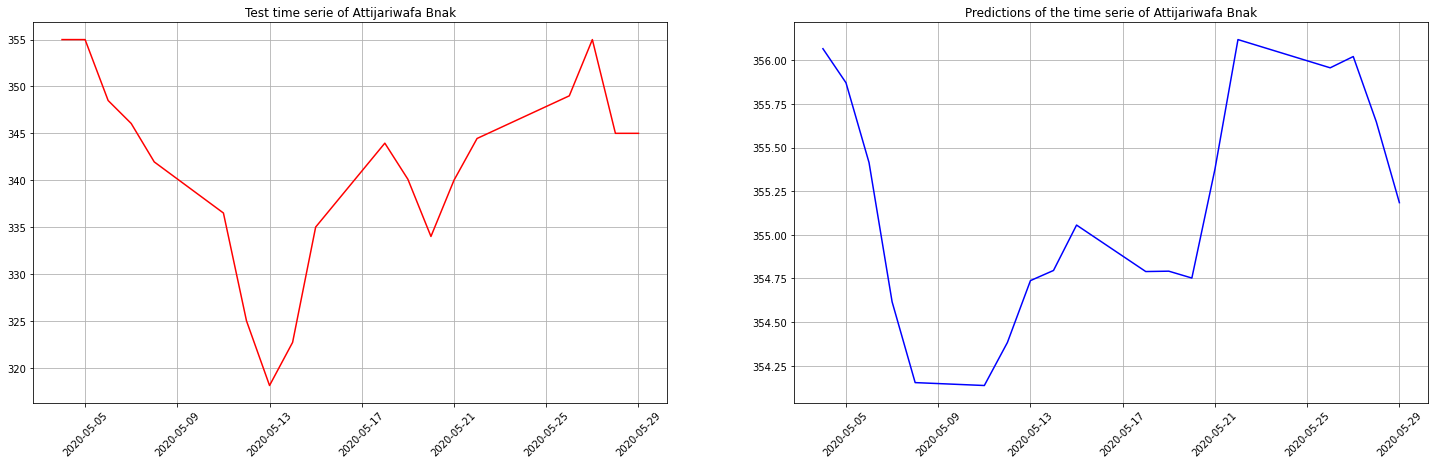

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7))
ax1.plot(test_forec.index, test_forec.iloc[:,0], color='r')
ax1.grid()
ax1.tick_params(axis='x', rotation=45)
ax1.set_title('Test time serie of Attijariwafa Bnak')
ax2.plot(test_forec.index, test_forec.iloc[:,1], color='b')
ax2.grid()
ax2.tick_params(axis='x', rotation=45)
ax2.set_title('Predictions of the time serie of Attijariwafa Bnak')
plt.show()

The predictions out of the sample were compared to their real value in the test set. In general, it seems that adding the seasonal orders could detect the trend during different period. However, we need a precise model that could detect these trends precisely, and why not have an approximate idea about the price of the stock.

**why didn't we use the library auto_arima of pdmarim time serie library:**
> In fact, we could use the auto_arima method of pdmarima library to run several models with several combinations of orders, but this task could take time to be runned and higher machine capacities to handle data. So, we are intrested more to figure out if SARIMA model could predicted the trend of a time serie, more than preditcing an approximate value of the stock price.

> The results with SARIMA model are not motivated, For that we will move forward to Machine learning algorithms to improve our predictions.